# **png2png** - mix two images / morphing animation between images

#### Used libraries: [Stable Diffusion](https://https://github.com/CompVis/stable-diffusion) / [imaginAIry](https://github.com/brycedrennan/imaginAIry) / [Birch-san](https://github.com/Birch-san/stable-diffusion) See their licenses for copyright terms. 
Following code licensed under AGPLv3.
###### Copyright (c) 2022 Dorofeev Alexandr


In [ ]:
#@title Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4497d603-3ab8-d8cb-a3cb-a76310b75712)


In [ ]:
#@title Press run. Wait til instance restart and then press on the next cell
%%capture
!pip install git+https://github.com/iVoider/imaginAIry.git@a3846580ed0fb6a1328eb1a3a363d970c54deb37 pillow --upgrade
!pip uninstall -y torchtext 

import os
os.kill(os.getpid(), 9)

In [1]:
#@title Setup
%%capture
from contextlib import nullcontext

from imaginairy.api import load_model
from PIL import Image
from PIL.Image import Resampling
from io import BytesIO
import requests

import torch
from torch import autocast

from imaginairy.img_utils import pillow_img_to_model_latent
from imaginairy.utils import get_device
from imaginairy.vendored import k_diffusion as K
from imaginairy.modules.find_noise import find_noise_for_image, from_noise


from imaginairy.samplers.base import get_sampler
from imaginairy.schema import ImaginePrompt, ImagineResult

from imaginairy import imagine, imagine_image_files, ImaginePrompt, WeightedPrompt, LazyLoadingImage
from imaginairy.enhancers.face_restoration_codeformer import enhance_faces

from einops import rearrange

from pytorch_lightning import seed_everything

import numpy as np

from pathlib import Path

import glob

import os
import subprocess
from IPython.display import HTML, display
from base64 import b64encode

import uuid

def parse_multiprompt(prompt):
  return [x.strip() for x in prompt.split(';')]

def prepare_images(frames_path, links, prompts, autogenerate_prompts = False):

  def crop_image(image):
    width, height = image.size
    if width == height:
        return image
    offset  = int(abs(height-width)/2)
    if width>height:
        image = image.crop([offset,0,width-offset,height])
    else:
        image = image.crop([0,offset,width,height-offset])
    return image

  def get_image(link):
    r = requests.get(link, headers={'User-agent': 'Mozilla/5.0'})
    img = Image.open(BytesIO(r.content)).convert('RGB')
    return crop_image(img).resize((512, 512), Resampling.LANCZOS)

  if os.path.isdir(frames_path) and not len(os.listdir(frames_path)) == 0:
    return "Directory is not empty!"
  else:
    os.makedirs(frames_path)
  
  if not links:
    return "Provide images to morph"
  
  images = [get_image(link) for link in links]

  if autogenerate_prompts:
    prompts = [interrogate(image, models=['ViT-L/14']) for image in images]
  elif not prompts:
    return "Provide prompts"

  for img in images:
    thumb = img.copy()
    thumb.thumbnail([256, 256])
    display(thumb)
  return images

def finetune_noises(model, images, prompts, negative_prompts, 
                    noise_restore_steps=300, noise_restore_prompt_strength=0.1):
  noises = []
  for i, img in enumerate(images):
   r = find_noise_for_image(model, img, prompts[i], negative_prompts[i], [1.0] * len(prompts[i]), 
                            [len(prompts[i])], noise_restore_steps, 1.0, True)
   noises.append(r)
  return noises

def showcase_noises(noises, prompts, negative_prompts, steps=50, prompt_strength=1.6):
 if prompt_strength == 1.0:
    prompt_strength = 1.01
 for i, noise in enumerate(noises):
  for c, f in from_noise([ImaginePrompt(sampler_type="k_euler", 
                                        steps=steps, 
                                        prompt_strength=prompt_strength)],
                          prompts=prompts[i],
                          negative_prompts = negative_prompts[i],
                          cond_weights=[1.0] * len(prompts[i]),
                          initial_noise_tensor=noise,
                          use_seq_weightning=True):
    thumb = f.img.copy()
    thumb.thumbnail([256, 256])
    display(thumb)

def slerp(t, v0, v1, DOT_THRESHOLD=0.9995):
    """helper function to spherically interpolate two arrays v1 v2"""

    if not isinstance(v0, np.ndarray):
        inputs_are_torch = True
        input_device = v0.device
        v0 = v0.cpu().numpy()
        v1 = v1.cpu().numpy()

    dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))
    if np.abs(dot) > DOT_THRESHOLD:
        v2 = (1 - t) * v0 + t * v1
    else:
        theta_0 = np.arccos(dot)
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1

    if inputs_are_torch:
        v2 = torch.from_numpy(v2).to(input_device)

    return v2

def make_video_ffmpeg(frame_dir, output_file_name='output.mp4', frame_filename="frame%06d.jpg", fps=30):
    frame_ref_path = str(frame_dir / frame_filename)
    video_path = str(frame_dir / output_file_name)
    subprocess.call(
        f"ffmpeg -r {fps} -i {frame_ref_path} -vcodec libx264 -crf 10 -pix_fmt yuv420p"
        f" {video_path}".split()
    )
    return video_path

def morph(start_prompt, end_prompt, start_negative_prompt, end_negative_prompt, start_noise, end_noise, length=3, num_steps=30,
          prompt_strength=1.6, max_strength=2.2, restore_faces=False, frame_filename_ext='.jpg', frames_path='/content/frames/'):

  output_path = Path(frames_path)
  cfg_axis = np.concatenate(((np.linspace(prompt_strength, max_strength, length // 2)) , 
                             (np.linspace(max_strength, prompt_strength, length // 2))), axis=None)

  for i, (t, cfg) in enumerate(zip(np.linspace(0, 1, length), cfg_axis)):
    current = slerp(float(t), start_noise, end_noise)
    for c, f in from_noise([ImaginePrompt(sampler_type="k_euler", steps=num_steps, prompt_strength=float(cfg))], 
                           prompts=start_prompt+end_prompt,
                           negative_prompts=start_negative_prompt,
                           cond_weights = [1.0 - t for _ in start_prompt] + [t for _ in end_prompt],
                           initial_noise_tensor=current,
                           use_seq_weightning=True
                           ):
     f.save(output_path / (f"frame%06d{frame_filename_ext}" % i))
  return make_video_ffmpeg(output_path)

def visualize_video_colab(video_path):
    mp4 = open(video_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

model = load_model().half()

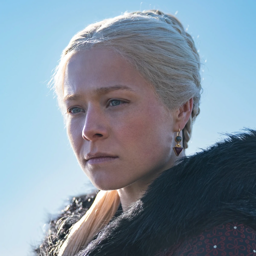

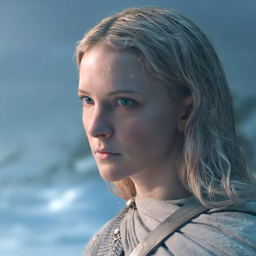

In [2]:
#@title Input data
#@markdown You should to write prompts to replicate image. If you have no idea about prompt - use CLIP Interrogator. Use ';' as divider for multiprompt.

start_image_link = 'https://i.imgur.com/FVhUxbm.png' #@param {type:"string"}
end_image_link = 'https://i.imgur.com/HEqWg6t.jpg' #@param {type:"string"}
links = [start_image_link, end_image_link]

autogenerate_prompts = False

start_image_prompt = 'head portrait photo of beautiful woman with blue eyes and fair hair on the sky background' #@param {type:"string"}
start_image_negative = 'contrast, art, painting, drawing, deformed eyes, blurry, tiled, rendered, headgear, hat, cap, headwear, ugly, fat, obese, chubby, (((deformed))), [blurry], bad anatomy, disfigured, poorly drawn face, mutation, mutated, (extra_limb), (ugly), (poorly drawn)' #@param {type:"string"}
end_image_prompt = 'head portrait photo of a beautiful young woman with blue eyes and blonde hair in the winter background' #@param {type:"string"}
end_image_negative = 'contrast, art, painting, drawing, deformed eyes, blurry, tiled, rendered, headgear, hat, cap, headwear, ugly, fat, obese, chubby, (((deformed))), [blurry], bad anatomy, disfigured, poorly drawn face, mutation, mutated, (extra_limb), (ugly), (poorly drawn)' #@param {type:"string"}
prompts = [parse_multiprompt(start_image_prompt), parse_multiprompt(end_image_prompt)]
negative_prompts = [parse_multiprompt(start_image_negative), parse_multiprompt(end_image_negative)]

frames_path = '/content/png2png/' + str(uuid.uuid4())

images = prepare_images(frames_path, links, prompts, autogenerate_prompts)

In [3]:
#@title Restore noise
#@markdown Experiment with config parametrs to get near exact input.

noises = None
noise_restore_steps = 85 #@param {type:"integer"}
noise_restore_prompt_strength = 1 #@param {type:"slider", min:-1, max:1, step:0.1}

noises = finetune_noises(model, images, prompts, negative_prompts, 
                         noise_restore_steps, noise_restore_prompt_strength)

  0%|          | 0/50 [00:00<?, ?it/s]

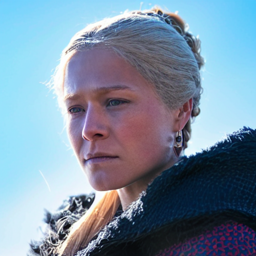

  0%|          | 0/50 [00:00<?, ?it/s]

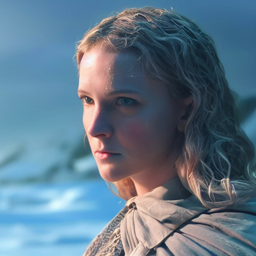

In [10]:
#@title Finetune restoration

steps = 50 #@param {type:"integer"}

prompt_strength = 0.8 #@param {type:"slider", min:0, max:30, step:0.1}

showcase_noises(noises, prompts, negative_prompts, steps, prompt_strength)

In [ ]:
#@title Generate video
length = 3 #@param {type:"integer"}
max_strength = 3 #@param {type:"slider", min:-1, max:24, step:0.1}
restore_faces = False
video_path = morph(prompts[0], prompts[1], negative_prompts[0], 
                   negative_prompts[1], noises[0], noises[1], 
                   length=length+1, prompt_strength=prompt_strength, 
                   max_strength=max_strength, frames_path=frames_path, 
                   num_steps=steps, restore_faces=restore_faces)

In [53]:
#@title Show video
visualize_video_colab(video_path)